<a href="https://colab.research.google.com/github/Zhuliang1/520PROJ2/blob/master/%E6%B3%A8%E6%84%8F%E5%8A%9B%E5%9B%BE%E5%8F%AF%E8%A7%86%E5%8C%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Populating the interactive namespace from numpy and matplotlib


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

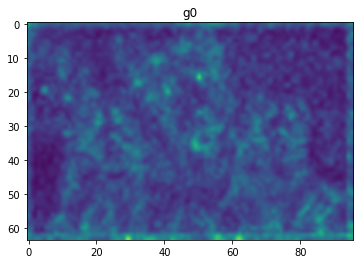

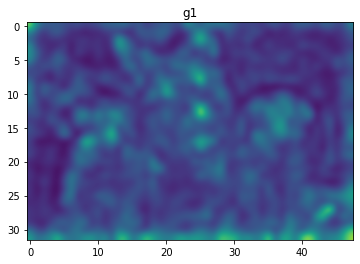

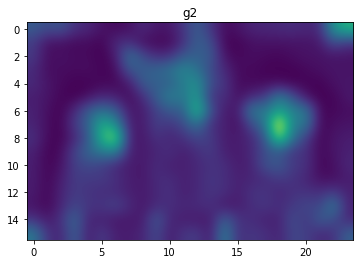

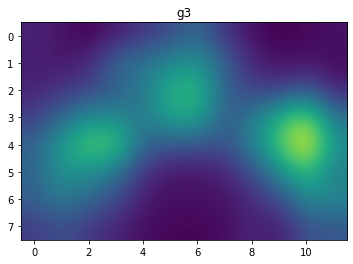

In [1]:
from PIL import Image
import requests
import numpy as np
from io import BytesIO
import torch
from torch import nn
from torchvision.models import resnet34
from torchvision.models.resnet import ResNet, BasicBlock
import torchvision.transforms as T
import torch.nn.functional as F
%pylab inline
 
 
 
base_resnet34 = resnet34(pretrained=True)
class ResNet34AT(ResNet):
    """Attention maps of ResNet-34.
    
    Overloaded ResNet model to return attention maps.
    """
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        g0 = self.layer1(x)
        g1 = self.layer2(g0)
        g2 = self.layer3(g1)
        g3 = self.layer4(g2)
        
        return [g.pow(2).mean(1) for g in (g0, g1, g2, g3)]
    
model = ResNet34AT(BasicBlock, [3, 4, 6, 3])
model.load_state_dict(base_resnet34.state_dict())
def load(url):
    response = requests.get(url)
    return np.ascontiguousarray(Image.open(BytesIO(response.content)), dtype=np.uint8)
im = load('http://www.zooclub.ru/attach/26000/26132.jpg')
plt.imshow(im)
tr_center_crop = T.Compose([
        T.ToPILImage(),
        T.Resize(256),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
model.eval()
with torch.no_grad():
    x = tr_center_crop(im).unsqueeze(0)
    gs = model(x)
for i, g in enumerate(gs):
    plt.imshow(g[0], interpolation='bicubic')
    plt.title(f'g{i}')
    plt.show()

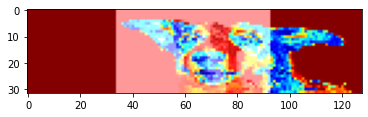

In [18]:
import cv2
import skimage
import skimage.viewer
import os
def resize(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cur_ratio = img.shape[1] / float(img.shape[0])
    target_ratio = 128 / float(32)
    mask_h = 32
    mask_w = 128
    img = np.array(img)
    if cur_ratio > target_ratio:
        cur_h = 32
        cur_w = 128
    else:
        cur_h = 32
        cur_w = int(32 * cur_ratio)
    img = cv2.resize(img, (cur_w, cur_h))
    start_y = (mask_h - img.shape[0]) // 2
    start_x = (mask_w - img.shape[1]) // 2
    mask = np.zeros([mask_h, mask_w, 3]).astype(np.uint8)
    mask[start_y: start_y + img.shape[0], start_x: start_x + img.shape[1], :] = img
    return mask
img_path="./"
img_name="1.jpg"
path="./"
att_map="1.jpg"
res_dir="./"
m="res_name.jpg"
img = skimage.io.imread(os.path.join(img_path, img_name))

#img=im
img_new = resize(img)
amap = cv2.cvtColor(skimage.io.imread(os.path.join(path, att_map)), cv2.COLOR_RGB2BGR)
new_map = cv2.resize(amap, (img_new.shape[1], img_new.shape[0]))
normed_mask = new_map / np.max(new_map)
normed_mask = np.uint8(255 * normed_mask)
normed_mask = cv2.applyColorMap(normed_mask, cv2.COLORMAP_JET)
normed_mask = cv2.addWeighted(img_new, 0.6, normed_mask, 1.0, 0)
skimage.io.imsave(os.path.join(res_dir, m), cv2.cvtColor(normed_mask, cv2.COLOR_BGR2RGB))
plt.imshow(cv2.cvtColor(normed_mask, cv2.COLOR_BGR2RGB))